# Przewidywanie bankructwa polskich przedsiębiorstw

Celem projektu jest zbudowanie modelu klasyfikacyjnego, który na podstawie wskaźników finansowych przewidzi upadłość firmy.

### Importowanie bibliotek i konfiguracja środowiska

In [1]:
import pandas as pd
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import wandb
from scipy.io import arff
from dotenv import load_dotenv

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, recall_score, precision_recall_curve, f1_score
from xgboost import XGBClassifier

from attributes import attributes_pl

# Ustawienia wyświetlania
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')

# Ustawienia kolorów
COLOR_HEALTHY = '#1f77b4'
COLOR_BANKRUPT = '#d62728'

YEAR_TO_ANALYZE = 3 # od 1 do 5
print(f"Analizowany rok: {YEAR_TO_ANALYZE}")

Analizowany rok: 3


## Część 1: Inżynieria danych i model bazowy

1.  **Wczytanie i unifikacja danych:** Wczytanie plików `.arff` i unifikacja.
2.  **Eksploracyjna analiza danych (EDA):** Zrozumienie danych, braków i korelacji.
3.  **Przetworzenie i podział danych:** Czyszczenie, podział, imputacja i skalowanie danych.
4.  **Analiza głównych składowych (PCA):** Redukcja wymiarowości.
5.  **Model bazowy (baseline):** Budowa prostego modelu odniesienia (regresja logistyczna).

### Wczytanie i unifikacja danych

Wczytanie danych z pliku `.arff`. Dane zawierają wskaźniki finansowe (Attr1 - Attr64) oraz etykietę klasy (`class`), gdzie:
* `0` - firma zdrowa
* `1` - bankrut

Następnie dane są dzielone zbiór na treningowy i testowy (proporcja 80/20).

In [2]:
file_path = f'data/{YEAR_TO_ANALYZE}year.arff'

try:
    data, meta = arff.loadarff(file_path)
    df = pd.DataFrame(data)
    
    df['class'] = df['class'].astype(int)
    
    print(f"Wczytano dane dla roku {YEAR_TO_ANALYZE}")
    print(f"Wymiary: {df.shape[0]} wierszy, {df.shape[1]} kolumn")
    
    display(df.head(5))
    
except FileNotFoundError:
    print(f"BŁĄD: Nie odnaleziono pliku: {file_path}")

Wczytano dane dla roku 3
Wymiary: 10503 wierszy, 65 kolumn


,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr37,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.174190,0.41299,0.14371,1.3480,-28.9820,0.60383,0.219460,1.1225,1.1961,0.46359,0.219460,0.531390,0.142330,0.219460,592.24,0.61630,2.4213,0.219460,0.122720,37.573,0.99690,0.295100,0.097402,0.75641,0.46359,0.50669,1.97370,0.32417,5.9473,0.224930,0.122720,100.820,3.6203,0.71453,0.295100,1.8079,123140.0000,0.46359,0.165010,0.212820,0.041124,0.165010,95.682,58.109,0.946210,0.90221,44.941,0.260030,0.145400,1.3480,0.41299,0.27622,1.0457,1.0458,127280.0,0.163960,0.375740,0.83604,0.000007,9.7145,6.2813,84.291,4.3303,4.0341,0
1,0.146240,0.46038,0.28230,1.6294,2.5952,0.00000,0.171850,1.1721,1.6018,0.53962,0.175790,0.383170,0.126470,0.171850,829.46,0.44004,2.1721,0.171850,0.107280,60.954,5.08890,0.175710,0.091295,NaN,0.17523,0.38442,44.59300,1.04860,4.0792,0.243840,0.109740,105.090,3.4733,3.38360,0.044076,1.6018,NaN,0.53962,0.027516,0.164060,0.074333,0.109690,149.750,88.801,0.546690,1.03300,62.678,0.144970,0.090503,1.5874,0.44849,0.28791,2.0044,2.0044,3387.8,0.027516,0.271000,0.90108,0.000000,5.9882,4.1103,102.190,3.5716,5.9500,0
2,0.000595,0.22612,0.48839,3.1599,84.8740,0.19114,0.004572,2.9881,1.0077,0.67566,0.004572,0.020219,0.030966,0.004572,2094.10,0.17430,4.4225,0.004572,0.003592,53.881,0.67451,0.040610,0.000468,0.23470,0.67566,0.15672,0.32153,1.71070,4.6220,0.036196,0.003592,65.345,5.5857,0.17960,0.040610,1.3425,NaN,0.67566,0.031907,0.844690,0.098528,0.031907,150.130,96.251,0.003168,2.32900,54.296,0.005769,0.004533,3.1599,0.22612,0.17903,2.3667,2.3667,20453.0,0.007639,0.000881,0.99236,0.000000,6.7742,3.7922,64.846,5.6287,4.4581,0
3,0.024526,0.43236,0.27546,1.7833,-10.1050,0.56944,0.024526,1.3057,1.0509,0.56453,0.024526,0.069747,0.036812,0.024526,3299.40,0.11063,2.3129,0.024526,0.018876,86.317,0.62795,0.055446,0.018876,0.56944,0.56453,0.11063,0.44844,0.73869,4.2600,0.286240,0.018876,103.810,3.5161,0.12824,0.055446,1.3068,3.9624,0.64524,0.042673,0.178260,0.180500,0.042673,158.550,72.237,0.079819,0.90954,90.707,0.032141,0.024737,1.4504,0.35164,0.28440,1.5139,1.7303,5012.6,0.048398,0.043445,0.95160,0.142980,4.2286,5.0528,98.783,3.6950,3.4844,0
4,0.188290,0.41504,0.34231,1.9279,-58.2740,0.00000,0.233580,1.4094,1.3393,0.58496,0.238810,0.633170,0.187800,0.233580,602.31,0.60600,2.4094,0.233580,0.174410,140.860,1.20390,0.234930,0.140590,0.00000,0.57250,0.49687,44.94700,1.18530,4.6033,0.306910,0.177840,122.090,2.9897,2.65740,0.236350,1.3393,4.5490,0.62769,0.176480,0.013769,0.054712,0.175420,192.450,51.585,0.364290,0.52685,171.050,0.216990,0.162030,1.7136,0.36891,0.33449,2.0256,2.1735,13730.0,0.176480,0.321880,0.82635,0.073039,2.5912,7.0756,100.540,3.6303,4.6375,0


### Eksploracyjna analiza danych (EDA)

1.  **Analiza braków danych:** Sprawdzenie, które wskaźniki finansowe są najczęściej niekompletne.
2.  **Rozkład klas:** Weryfikacja, jak bardzo niezbalansowany jest zbiór (stosunek firm zdrowych do bankrutów).
3.  **Korelacje:** Szukanie cech, które mają najsilniejszy związek (dodatni lub ujemny) z bankructwem.

/tmp/ipykernel_36303/3271439735.py:15: UserWarning: The palette list has more values (25) than needed (20), which may not be intended.
  ax = sns.barplot(


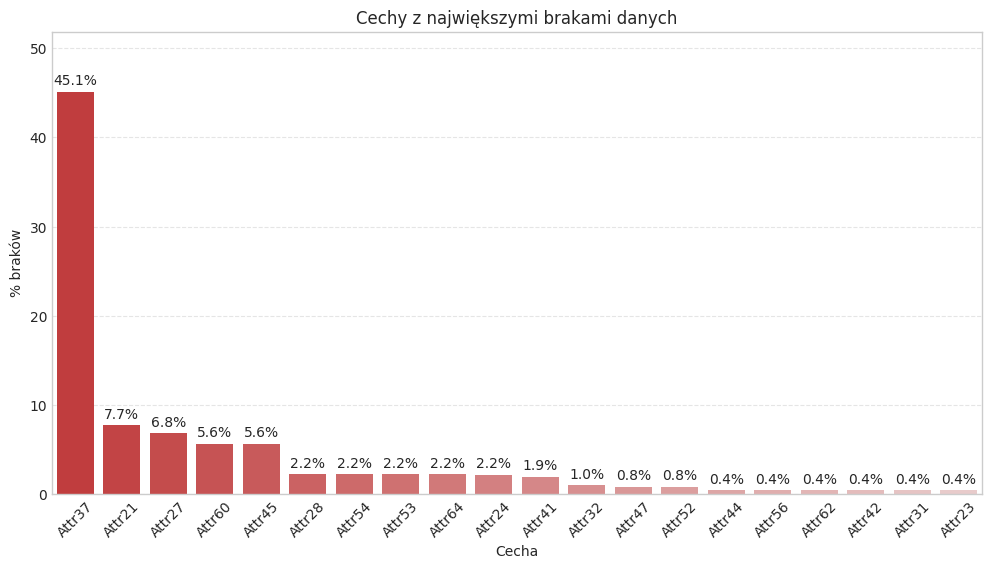

LEGENDA
Attr37: (aktywa obrotowe - zapasy) / zobowiązania długoterminowe
Attr21: przychody ze sprzedaży (n) / przychody ze sprzedaży (n-1)
Attr27: zysk z działalności operacyjnej / koszty finansowe
Attr60: przychody ze sprzedaży / zapasy
Attr45: zysk netto / zapasy
Attr28: kapitał obrotowy / aktywa trwałe
Attr54: kapitał stały / aktywa trwałe
Attr53: kapitał własny / aktywa trwałe
Attr64: przychody ze sprzedaży / aktywa trwałe
Attr24: zysk brutto (w 3 lata) / aktywa ogółem
Attr41: zobowiązania ogółem / ((zysk z dział. operacyjnej + amortyzacja) * (12/365))
Attr32: (zobowiązania bieżące * 365) / koszt własny sprzedaży
Attr47: (zapasy * 365) / koszt własny sprzedaży
Attr52: (zobowiązania krótkoterminowe * 365) / koszt własny sprzedaży
Attr44: (należności * 365) / przychody ze sprzedaży
Attr56: (przychody ze sprzedaży - koszt własny sprzedaży) / przychody ze sprzedaży
Attr62: (zobowiązania krótkoterminowe * 365) / przychody ze sprzedaży
Attr42: zysk z działalności operacyjnej / przychody 

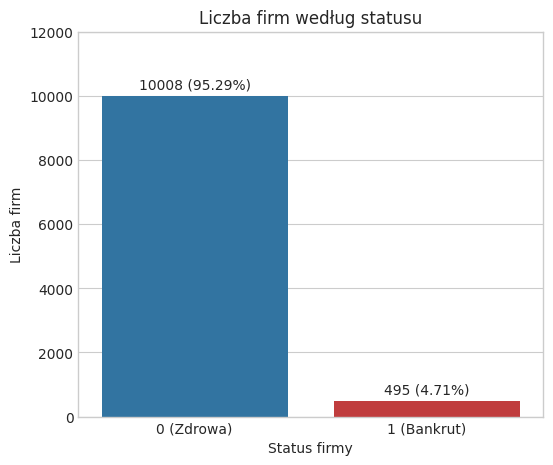

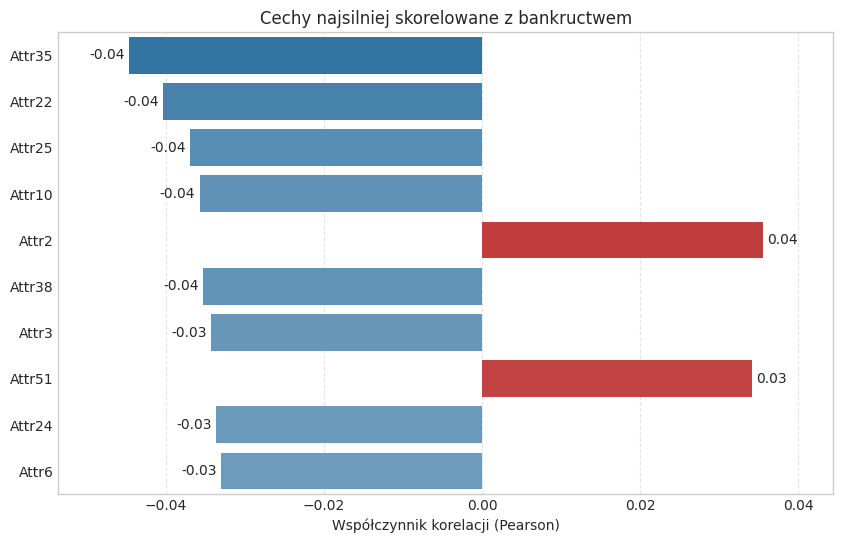

LEGENDA
Attr35: zysk na sprzedaży / aktywa ogółem
Attr22: zysk z działalności operacyjnej / aktywa ogółem
Attr25: (kapitał własny - kapitał zakładowy) / aktywa ogółem
Attr10: kapitał własny / aktywa ogółem
Attr2: zobowiązania ogółem / aktywa ogółem
Attr38: kapitał stały / aktywa ogółem
Attr3: kapitał obrotowy / aktywa ogółem
Attr51: zobowiązania krótkoterminowe / aktywa ogółem
Attr24: zysk brutto (w 3 lata) / aktywa ogółem
Attr6: zyski zatrzymane / aktywa ogółem


In [3]:
# Ustawienia kolorów
BINARY_PALETTE = [COLOR_HEALTHY, COLOR_BANKRUPT]

cmap_diverging = mcolors.LinearSegmentedColormap.from_list("CustomRdBu", [COLOR_HEALTHY, "white", COLOR_BANKRUPT])

# 1. ANALIZA BRAKÓW DANYCH
missing = df.isnull().sum() / len(df) * 100
missing = missing[missing > 0].sort_values(ascending=False)

plt.figure(figsize=(12, 6))

if not missing.empty:
    top_missing = missing.head(20)
    
    ax = sns.barplot(
        x=top_missing.index, 
        y=top_missing.values, 
        hue=top_missing.index, 
        legend=False, 
        palette=sns.light_palette(COLOR_BANKRUPT, n_colors=25, reverse=True)
    )
    
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%', padding=3)

    plt.title(f'Cechy z największymi brakami danych')
    plt.xlabel('Cecha')
    plt.ylabel('% braków')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.xticks(rotation=45)
    
    max_missing = top_missing.max()
    limit = max_missing * 1.15 if max_missing > 0 else 10

    plt.ylim(0, limit)
    
    plt.show()
    
    print("LEGENDA")
    for attr in top_missing.index[:20]:
         print(f"{attr}: {attributes_pl.get(attr, 'Brak opisu')}")
else:
    print("Brak pustych wartości")

# 2. ROZKŁAD KLAS
plt.figure(figsize=(6, 5))

ax = sns.countplot(x='class', data=df, hue='class', legend=False, palette=BINARY_PALETTE)

total = len(df)

for container in ax.containers:
    labels = [f'{int(v.get_height())} ({v.get_height()/total*100:.2f}%)' for v in container]
    ax.bar_label(container, labels=labels, label_type='edge', padding=3)

plt.title(f'Liczba firm według statusu')
plt.xlabel('Status firmy')
plt.ylabel('Liczba firm')
plt.xticks([0, 1], ['0 (Zdrowa)', '1 (Bankrut)'])

max_height = max([p.get_height() for p in ax.patches])

plt.ylim(0, max_height * 1.2)

plt.show()

# 3. KORELACJE
correlations = df.corr()['class'].sort_values()
top_corr = correlations.abs().sort_values(ascending=False).head(11) 
top_corr_names = top_corr.index.tolist()

if 'class' in top_corr_names: top_corr_names.remove('class')

plt.figure(figsize=(10, 6))

corr_values = correlations[top_corr_names].values
norm = plt.Normalize(corr_values.min(), corr_values.max())
colors = cmap_diverging(norm(corr_values))

ax = sns.barplot(
    x=corr_values, 
    y=top_corr_names, 
    hue=corr_values, 
    legend=False, 
    palette=cmap_diverging
)

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=3)

plt.title('Cechy najsilniej skorelowane z bankructwem')
plt.xlabel('Współczynnik korelacji (Pearson)')
plt.grid(axis='x', linestyle='--', alpha=0.5)

min_val = corr_values.min()
max_val = corr_values.max()
padding = max(abs(min_val), abs(max_val)) * 0.2

plt.xlim(min_val - padding, max_val + padding)

plt.show()

print("LEGENDA")
for attr in top_corr_names:
    print(f"{attr}: {attributes_pl.get(attr, 'Brak opisu')}")

### Przetworzenie i podział danych

Na podstawie analizy braków danych zdecydowano usunąć cechę `Attr37`, która posiada zbyt wiele pustych wartości, by je bezpiecznie uzupełniać.

Następnie:
1.  **Podział (Train/Test):** Dane dzielone są w proporcji 80/20 z zachowaniem proporcji klas (`stratify`).
2.  **Pipeline:**
    * **Imputacja:** Braki uzupełniane są medianą.
    * **Skalowanie:** Dane są standaryzowane (`StandardScaler`), co jest wymagane dla PCA i regresji logistycznej.

In [4]:
# 1. PRZYGOTOWANIE DANYCH
# Usunięcie cechy Attr37
if 'Attr37' in df.columns:
    X = df.drop(['class', 'Attr37'], axis=1)
    print("Usunięto kolumnę Attr37")
else:
    X = df.drop('class', axis=1)
    print("Kolumna Attr37 nie istnieje")

y = df['class']

feature_names_final = X.columns.tolist()
print(f"Liczba cech do analizy: {X.shape[1]}")

# 2. PODZIAŁ DANYCH
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Rozmiar zbioru treningowego: {X_train.shape}")
print(f"Rozmiar zbioru testowego:  {X_test.shape}")
print(f"Liczba bankrutów w zbiorze testowym: {y_test.sum()} (na {len(y_test)} firm)")

# 3. PIPELINE PRZETWARZANIA DANYCH
preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), # mediana jest odporna na wartości odstające
    ('scaler', StandardScaler()) # średnia=0, odchylenie=1
])

# 4. DOPASOWANIE I TRANSFORMACJA DANYCH
# Pipeline jest dopasowywany do zbioru treningowego
X_train_scaled = preprocessor.fit_transform(X_train)
# Zbiór testowy jest transformowany na podstawie parametrów wyuczonych na zbiorze treningowym
X_test_scaled = preprocessor.transform(X_test)

# Zamiana na DataFrame (dla wygody operowania nazwami kolumn)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names_final)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names_final)

Usunięto kolumnę Attr37
Liczba cech do analizy: 63
Rozmiar zbioru treningowego: (8402, 63)
Rozmiar zbioru testowego:  (2101, 63)
Liczba bankrutów w zbiorze testowym: 99 (na 2101 firm)


### Analiza głównych składowych (PCA)

Dane mają 63 wymiary, co utrudnia wizualizację. Zastosowano PCA, aby sprawdzić, czy bankruci tworzą oddzielne skupisko.

Wariancja wyjaśniona przez PC1: 16.76%
Wariancja wyjaśniona przez PC2: 12.76%
Suma informacji na wykresie: 29.52%


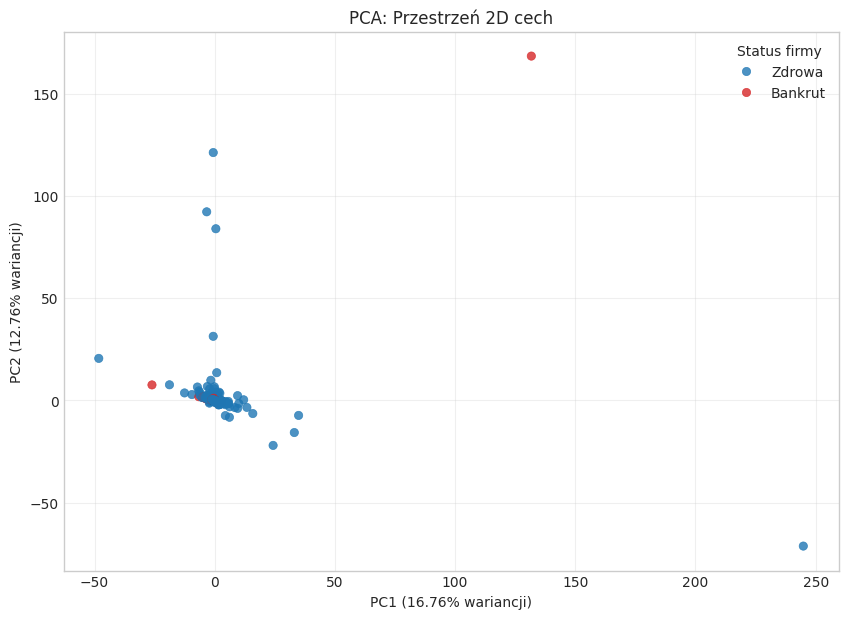

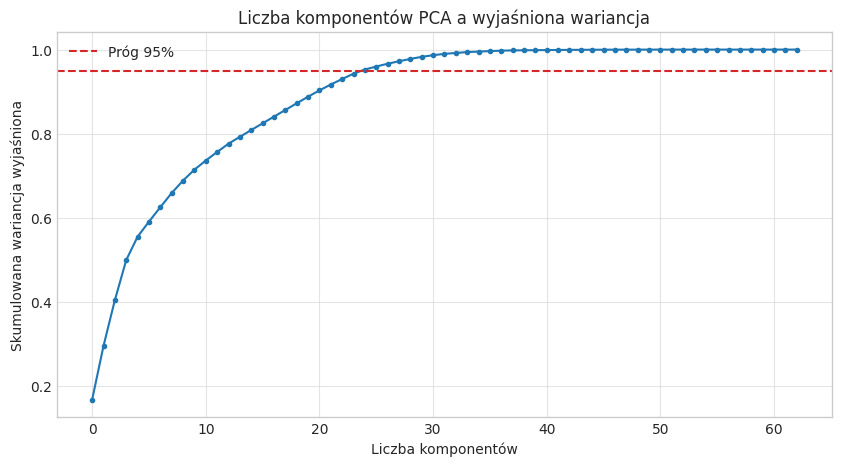

In [5]:
# Ustawienia kolorów
palette_dict = {'Zdrowa': COLOR_HEALTHY, 'Bankrut': COLOR_BANKRUPT}

# 1. URUCHOMIENIE PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

df_pca = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
df_pca['class'] = y_train.values
df_pca['Legenda'] = df_pca['class'].map({0: 'Zdrowa', 1: 'Bankrut'})

# 2. LICZBA WARIANCJI WYJAŚNIONEJ
evr = pca.explained_variance_ratio_
print(f"Wariancja wyjaśniona przez PC1: {evr[0]:.2%}")
print(f"Wariancja wyjaśniona przez PC2: {evr[1]:.2%}")
print(f"Suma informacji na wykresie: {sum(evr):.2%}")

# 3. WIZUALIZACJA PCA
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x='PC1', y='PC2', 
    hue='Legenda',
    data=df_pca, 
    palette=palette_dict,
    alpha=0.8,
    edgecolor=None
)
plt.title(f'PCA: Przestrzeń 2D cech')
plt.xlabel(f'PC1 ({evr[0]:.2%} wariancji)')
plt.ylabel(f'PC2 ({evr[1]:.2%} wariancji)')
plt.legend(title='Status firmy') 
plt.grid(True, alpha=0.3)
plt.show()

# 4. WYBÓR LICZBY KOMPONENTÓW PCA
pca_full = PCA().fit(X_train_scaled)

plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_), marker='.', linestyle='-', color=COLOR_HEALTHY)
plt.xlabel('Liczba komponentów')
plt.ylabel('Skumulowana wariancja wyjaśniona')
plt.title('Liczba komponentów PCA a wyjaśniona wariancja')
plt.axhline(y=0.95, color=COLOR_BANKRUPT, linestyle='--', label='Próg 95%')
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

### Model bazowy (baseline): Regresja logistyczna

Jako punkt odniesienia wytrenowana została regresja logistyczna.
Używany jest parametr `class_weight='balanced'`, aby zmusić model do zwracania uwagi na mniejszą klasę bankrutów (w przeciwnym razie model mógłby ignorować bankrutów i wciąż mieć wysoką ogólną dokładność).

Trening modelu bazowego...
WYNIKI
ROC AUC: 0.7418
Raport klasyfikacji:
              precision    recall  f1-score   support

           0       0.98      0.66      0.79      2002
           1       0.09      0.72      0.17        99

    accuracy                           0.66      2101
   macro avg       0.54      0.69      0.48      2101
weighted avg       0.94      0.66      0.76      2101



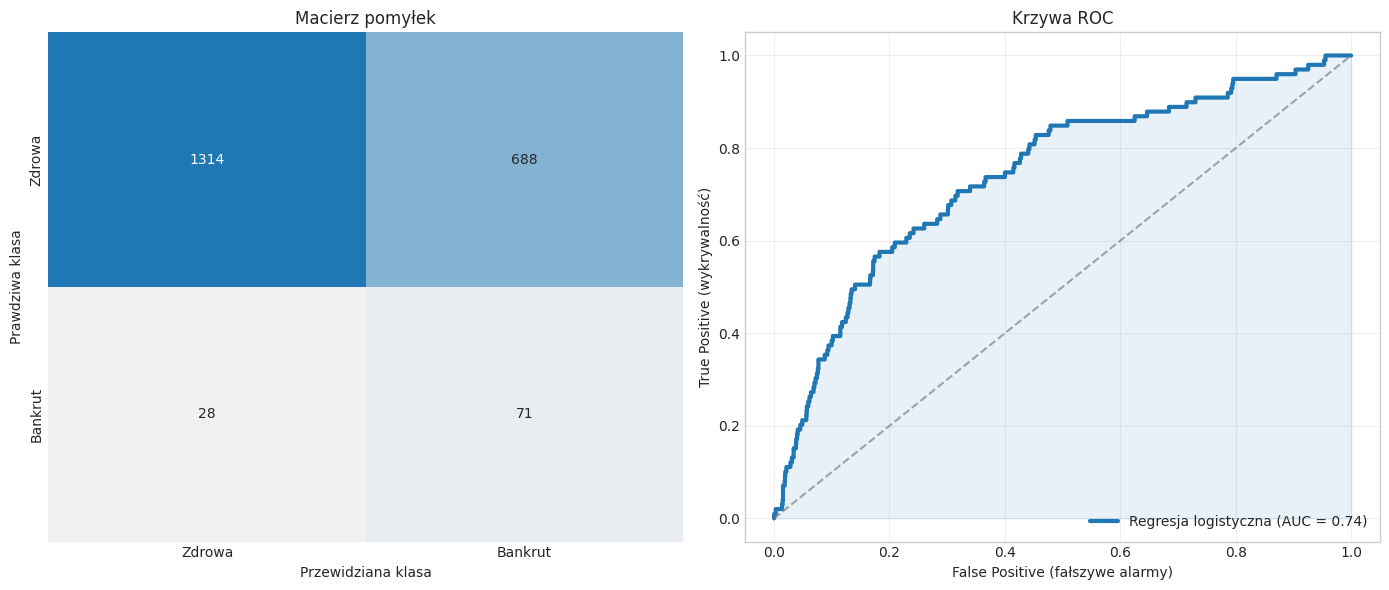

In [6]:
# 1. TRENING
log_reg = LogisticRegression(class_weight='balanced', max_iter=2000, random_state=42)

print("Trening modelu bazowego...")
log_reg.fit(X_train_scaled, y_train)

# 2. PREDYKCJA
y_pred_base = log_reg.predict(X_test_scaled)
y_proba_base = log_reg.predict_proba(X_test_scaled)[:, 1]

# 3. WYNIKI
auc_base = roc_auc_score(y_test, y_proba_base)

print(f"WYNIKI")
print(f"ROC AUC: {auc_base:.4f}")
print("Raport klasyfikacji:")
print(classification_report(y_test, y_pred_base))

# 4. WIZUALIZACJE (macierz pomyłek i krzywa ROC)
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Macierz Pomyłek
cmap_cm = sns.light_palette(COLOR_HEALTHY, as_cmap=True)

cm = confusion_matrix(y_test, y_pred_base)
sns.heatmap(cm, annot=True, fmt='d', cmap=cmap_cm, cbar=False, ax=ax[0])

ax[0].set_title('Macierz pomyłek')
ax[0].set_xlabel('Przewidziana klasa')
ax[0].set_ylabel('Prawdziwa klasa')
ax[0].set_xticklabels(['Zdrowa', 'Bankrut'])
ax[0].set_yticklabels(['Zdrowa', 'Bankrut'])

# Krzywa ROC
fpr, tpr, thresholds = roc_curve(y_test, y_proba_base)

ax[1].plot(fpr, tpr, label=f'Regresja logistyczna (AUC = {auc_base:.2f})', color=COLOR_HEALTHY, linewidth=3)
ax[1].fill_between(fpr, tpr, color=COLOR_HEALTHY, alpha=0.1)
ax[1].plot([0, 1], [0, 1], color='gray', linestyle='--', alpha=0.7) 
ax[1].set_xlabel('False Positive (fałszywe alarmy)')
ax[1].set_ylabel('True Positive (wykrywalność)')
ax[1].set_title('Krzywa ROC')
ax[1].legend(loc='lower right')
ax[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Część 2: Zaawansowane modelowanie

1.  **Random Forest:** Model odporny na overfitting.
2.  **XGBoost:** Obecny standard w konkursach ML.
3.  **Threshold tuning:** Manipulacja progiem decyzyjnym, aby zmaksymalizować wykrywalność bankrutów (recall).
4.  **WandB:** Śledzenie eksperymentów w chmurze.

In [7]:
# Import słownika
try:
    from attributes import attributes_pl
except ImportError:
    attributes_pl = {}

# 1. ZAŁADOWANIE KONFIGURACJI
load_dotenv()

# Pobranie klucza API
api_key = os.getenv("WANDB_API_KEY")

if not api_key:
    print("UWAGA: Nie znaleziono WANDB_API_KEY")

try:
    print("Logowanie do WandB...")
    wandb.login(key=api_key)
    print("Zalogowano pomyślnie")
except Exception as e:
    print(f"BŁĄD: Nieudana próba logowania do WandB: {e}")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: [wandb.login()] Using explicit session credentials for https://api.wandb.ai.
wandb: Appending key for api.wandb.ai to your netrc file: /home/jakub/.netrc


Logowanie do WandB...


wandb: Currently logged in as: scbpls (polish-bankruptcy-prediction) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Zalogowano pomyślnie


### Eksperyment 1: Lasy losowe (random forest)

Algorytm, który buduje wiele drzew decyzyjnych i uśrednia ich wyniki.
* **Strategia na niezbalansowanie:** Użyto `class_weight='balanced'`, co automatycznie zwiększa kary za błędy na klasie mniejszościowej (bankrutach).
* **Feature importance:** Model ten pozwala łatwo ocenić, które wskaźniki finansowe są kluczowe dla predykcji.

In [8]:
# 1. KONFIGURACJA RUNU
run_config_rf = {
    "model_type": "Random Forest",
    "n_estimators": 100,
    "max_depth": 10,
    "class_weight": "balanced",
    "year": YEAR_TO_ANALYZE
}

# 2. INICJALIZACJA RUNU
run = wandb.init(
    project="polish-bankruptcy-prediction",
    config=run_config_rf,
    name=f"RF_Year{YEAR_TO_ANALYZE}_Balanced",
    reinit=True
)

# 3. TRENING
print("Trening lasu losowego...")
start_time = time.time()

rf_model = RandomForestClassifier(
    n_estimators=run_config_rf["n_estimators"],
    max_depth=run_config_rf["max_depth"],
    class_weight=run_config_rf["class_weight"],
    random_state=42,
    n_jobs=1,
    verbose=0
)

rf_model.fit(X_train_scaled, y_train)
print(f"Trening zakończony w {time.time() - start_time:.2f} s")

# 4. EWALUACJA
y_pred_rf = rf_model.predict(X_test_scaled)
y_proba_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

auc_rf = roc_auc_score(y_test, y_proba_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

print("WYNIKI")
print(f"ROC AUC:  {auc_rf:.4f}")
print(f"RECALL:   {recall_rf:.4f}")
print(f"F1 SCORE: {f1_rf:.4f}")
print(classification_report(y_test, y_pred_rf))

# 5. WIZUALIZACJA WAŻNOŚCI CECH
importances = rf_model.feature_importances_
feature_imp_df = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(10)

feature_imp_df['Opis'] = feature_imp_df['Feature'].map(attributes_pl).fillna(feature_imp_df['Feature'])

plt.figure(figsize=(10, 6))

custom_palette = sns.light_palette(COLOR_HEALTHY, n_colors=10, reverse=True)

ax = sns.barplot(
    x='Importance', 
    y='Opis', 
    hue='Opis',
    data=feature_imp_df, 
    palette=custom_palette,
    legend=False
)

for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3)

plt.title('Najważniejsze cechy według lasu losowego')
plt.xlabel('Ważność (wskaźnik Giniego)')
plt.ylabel('')

max_val = feature_imp_df['Importance'].max()

plt.xlim(0, max_val * 1.15) 
plt.close()

# 6. LOGOWANIE WYNIKÓW DO WANDB
wandb.log({
    "roc_auc": auc_rf,
    "recall": recall_rf,
    "f1_score": f1_rf,
    "confusion_matrix": wandb.plot.confusion_matrix(
        probs=None, y_true=y_test.values, preds=y_pred_rf, class_names=["Zdrowa", "Bankrut"]
    ),
    "roc_curve": wandb.plot.roc_curve(
        y_test.values, rf_model.predict_proba(X_test_scaled), labels=["Zdrowa", "Bankrut"]
    )
})
run.finish()

wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Trening lasu losowego...
Trening zakończony w 2.40 s
WYNIKI
ROC AUC:  0.8397
RECALL:   0.2929
F1 SCORE: 0.3452
              precision    recall  f1-score   support

           0       0.97      0.98      0.97      2002
           1       0.42      0.29      0.35        99

    accuracy                           0.95      2101
   macro avg       0.69      0.64      0.66      2101
weighted avg       0.94      0.95      0.94      2101



f1_score,▁
recall,▁
roc_auc,▁
f1_score,0.34524
recall,0.29293
roc_auc,0.83968


### Analiza progu decyzyjnego (threshold tuning)

Większość modeli domyślnie klasyfikuje firmę jako bankruta, jeśli prawdopodobieństwo wynosi $> 50\%$. W przypadku danych niezbalansowanych to podejście często zawodzi – model jest zbyt "ostrożny".

Poniżej analizowana jest **krzywa Precyzja-Recall**, która przedstawia dylemat:
* Czy wykrywać wszystkich bankrutów (**wysoki recall**), ale mieć dużo fałszywych alarmów?
* Czy mieć pewność, że oznaczone przedsiębiorstwo na pewno zbankrutuje (**wysoka precyzja**), ale wielu zostanie przeoczonych?

WYNIKI PO ZMIANIE PROGU NA 0.2
              precision    recall  f1-score   support

           0       0.99      0.72      0.84      2002
           1       0.13      0.81      0.22        99

    accuracy                           0.73      2101
   macro avg       0.56      0.77      0.53      2101
weighted avg       0.95      0.73      0.81      2101



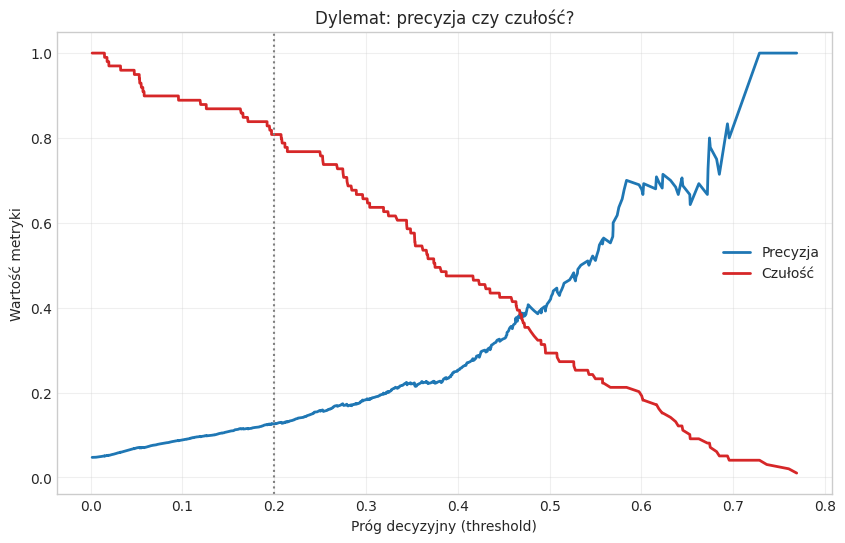

In [9]:
# 1. DEFINICJA NOWEGO PROGU
NEW_THRESHOLD = 0.2

# 2. DOSTOSOWANIE PREDYKCJI
y_pred_adjusted = (y_proba_rf >= NEW_THRESHOLD).astype(int)

# 3. SPRAWDZENIE NOWYCH WYNIKÓW
print(f"WYNIKI PO ZMIANIE PROGU NA {NEW_THRESHOLD}")
print(classification_report(y_test, y_pred_adjusted))

# 4. WIZUALIZACJA DYLEMATU
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba_rf)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions[:-1], label='Precyzja', color=COLOR_HEALTHY, linewidth=2)
plt.plot(thresholds, recalls[:-1], label='Czułość', color=COLOR_BANKRUPT, linewidth=2)
plt.xlabel('Próg decyzyjny (threshold)')
plt.ylabel('Wartość metryki')
plt.title('Dylemat: precyzja czy czułość?')
plt.legend()
plt.grid(True, alpha=0.3)
plt.axvline(x=NEW_THRESHOLD, color='gray', linestyle=':', label=f'Próg {NEW_THRESHOLD}')

plt.show()

### Eksperyment 2: XGBoost (eXtreme Gradient Boosting)

Aby poradzić sobie z małą liczbą bankrutów, zastosowano parametr `scale_pos_weight`. Mówi on modelowi, że **błąd na bankrucie jest X razy bardziej kosztowny** niż błąd na zdrowej firmie.

Wyliczona waga dla klasy bankrutów: 20.22


Trening XGBoost...
Trening zakończony w 1.08 s
WYNIKI
ROC AUC: 0.9132
RECALL:  0.5051
F1 SCORE:  0.5682
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2002
           1       0.65      0.51      0.57        99

    accuracy                           0.96      2101
   macro avg       0.81      0.75      0.77      2101
weighted avg       0.96      0.96      0.96      2101



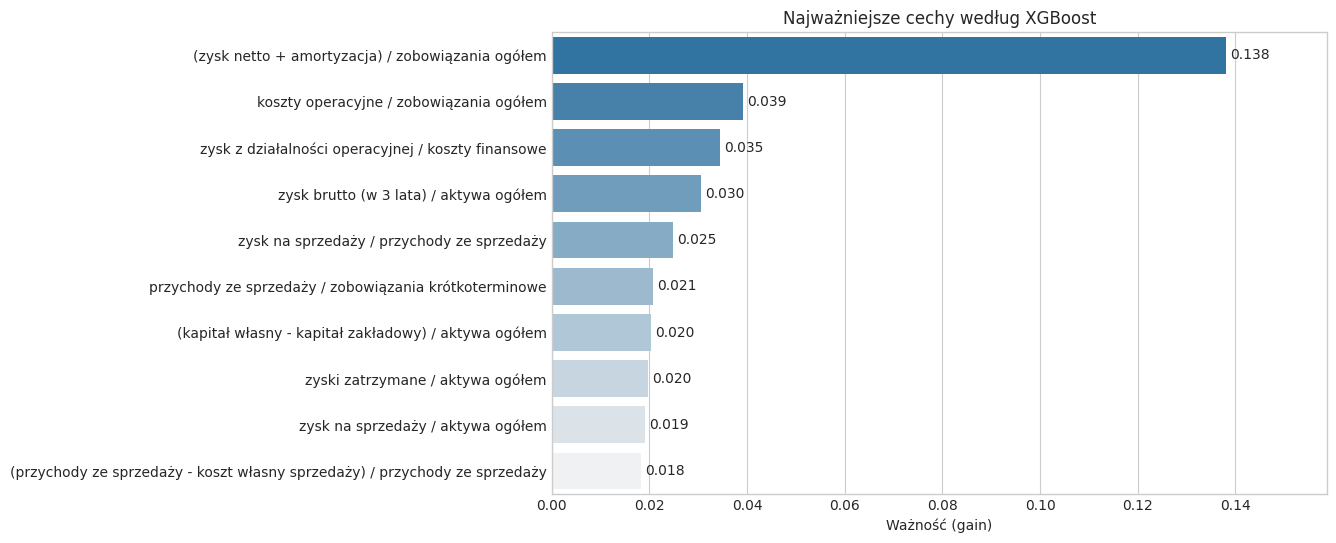

f1_score,▁
recall,▁
roc_auc,▁
f1_score,0.56818
recall,0.50505
roc_auc,0.91315


In [10]:
# 1. OBLICZENIE WAGI KLASY MNIEJSZOŚCIOWEJ
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Wyliczona waga dla klasy bankrutów: {scale_pos_weight:.2f}")

# 2. KONFIGURACJA RUNU
run_config_xgb = {
    "model_type": "XGBoost",
    "n_estimators": 100,
    "max_depth": 6,
    "learning_rate": 0.1,
    "scale_pos_weight": scale_pos_weight,
    "year": YEAR_TO_ANALYZE
}

# 3. INICJALIZACJA RUNU
run = wandb.init(
    project="polish-bankruptcy-prediction",
    config=run_config_xgb,
    name=f"XGB_Year{YEAR_TO_ANALYZE}",
    reinit=True
)

# 4. TRENING
print("Trening XGBoost...")
start_time = time.time()

xgb_model = XGBClassifier(
    n_estimators=run_config_xgb["n_estimators"],
    max_depth=run_config_xgb["max_depth"],
    learning_rate=run_config_xgb["learning_rate"],
    scale_pos_weight=run_config_xgb["scale_pos_weight"],
    random_state=42,
    n_jobs=1,
    eval_metric='auc',
    verbosity=0
)

xgb_model.fit(X_train_scaled, y_train)
print(f"Trening zakończony w {time.time() - start_time:.2f} s")

# 5. EWALUACJA
y_pred_xgb = xgb_model.predict(X_test_scaled)
y_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]

auc_xgb = roc_auc_score(y_test, y_proba_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)

print("WYNIKI")
print(f"ROC AUC: {auc_xgb:.4f}")
print(f"RECALL:  {recall_xgb:.4f}")
print(f"F1 SCORE:  {f1_xgb:.4f}")
print(classification_report(y_test, y_pred_xgb))

# 6. WIZUALIZACJA WAŻNOŚCI CECH
importances = xgb_model.feature_importances_
feature_imp_df = pd.DataFrame({
    'Feature': X_train_scaled.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(10)

feature_imp_df['Opis'] = feature_imp_df['Feature'].map(attributes_pl).fillna(feature_imp_df['Feature'])

plt.figure(figsize=(10, 6))

custom_palette = sns.light_palette(COLOR_HEALTHY, n_colors=10, reverse=True)

ax = sns.barplot(
    x='Importance', 
    y='Opis', 
    hue='Opis',
    data=feature_imp_df, 
    palette=custom_palette,
    legend=False
)

for container in ax.containers:
    ax.bar_label(container, fmt='%.3f', padding=3)

plt.title('Najważniejsze cechy według XGBoost')
plt.xlabel('Ważność (gain)')
plt.ylabel('')
plt.xlim(0, feature_imp_df['Importance'].max() * 1.15) 
plt.show()

# 7. LOGOWANIE WYNIKÓW DO WANDB
wandb.log({
    "roc_auc": auc_xgb,
    "recall": recall_xgb,
    "f1_score": f1_xgb,
    "confusion_matrix": wandb.plot.confusion_matrix(
        probs=None, y_true=y_test.values, preds=y_pred_xgb, class_names=["Zdrowa", "Bankrut"]
    ),
    "roc_curve": wandb.plot.roc_curve(
        y_test.values, xgb_model.predict_proba(X_test_scaled), labels=["Zdrowa", "Bankrut"]
    ),
    "feature_importance": wandb.plot.bar(
        wandb.Table(dataframe=feature_imp_df[['Feature', 'Importance']]), 
        "Feature", "Importance", title="Top Cechy (XGBoost)"
    )
})

run.finish()

### Finalna optymalizacja: Dostrojenie progu pod biznes

W kontekście bankowym/inwestycyjnym koszt przeoczenia bankructwa (utrata kapitału) jest drastycznie wyższy niż koszt sprawdzenia fałszywego alarmu.

Dlatego w tym kroku **nie ufa się domyślnemu progowi**. Ustawiono cel biznesowy na **wykrycie co najmniej 85% bankrutów** (recall $\approx$ 0,85) i sprawdzono, jaki próg prawdopodobieństwa pozwoli to osiągnąć.

OPTYMALIZACJA PROGU (XGBoost)
Cel: Recall ~ 85.0%
Znaleziony optymalny próg: 0.0777
WYNIKI
RECALL: 0.8485
F1 SCORE: 0.3158
              precision    recall  f1-score   support

           0       0.99      0.83      0.90      2002
           1       0.19      0.85      0.32        99

    accuracy                           0.83      2101
   macro avg       0.59      0.84      0.61      2101
weighted avg       0.95      0.83      0.87      2101



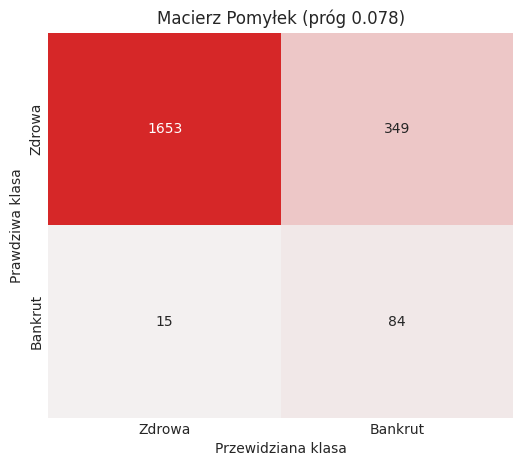

final_auc,▁
final_f1,▁
final_recall,▁
optimal_threshold,▁
final_auc,0.91315
final_f1,0.31579
final_recall,0.84848
optimal_threshold,0.07771


In [11]:
# 1. INICJALIZACJA RUNU
run = wandb.init(
    project="polish-bankruptcy-prediction",
    name=f"XGB_Optimization_Year{YEAR_TO_ANALYZE}",
    config={"threshold_tuning": True},
    reinit=True
)

# 2. PREDYKCJA POCZĄTKOWA
y_proba_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1] # z poprzedniego kroku

# 3. OPTYMALIZACJA PROGU DECYZYJNEGO
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba_xgb)

TARGET_RECALL = 0.85 # cel
optimal_idx = np.argmin(np.abs(recalls - TARGET_RECALL))
optimal_threshold = thresholds[optimal_idx]

print(f"OPTYMALIZACJA PROGU (XGBoost)")
print(f"Cel: Recall ~ {TARGET_RECALL*100}%")
print(f"Znaleziony optymalny próg: {optimal_threshold:.4f}")

# 4. PREDYKCJA Z NOWYM PROGIEM
y_pred_opt = (y_proba_xgb >= optimal_threshold).astype(int)

# 5. EWALUACJA FINALNA
final_recall = recall_score(y_test, y_pred_opt)
final_auc = roc_auc_score(y_test, y_proba_xgb)
final_f1 = f1_score(y_test, y_pred_opt)

print("WYNIKI")
print(f"RECALL: {final_recall:.4f}")
print(f"F1 SCORE: {final_f1:.4f}")
print(classification_report(y_test, y_pred_opt))

# 6. WIZUALIZACJA MACIERZY POMYŁEK
plt.figure(figsize=(6, 5))

cmap_opt = sns.light_palette(COLOR_BANKRUPT, as_cmap=True)

cm = confusion_matrix(y_test, y_pred_opt)

sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap=cmap_opt, 
    cbar=False,
    xticklabels=['Zdrowa', 'Bankrut'],
    yticklabels=['Zdrowa', 'Bankrut']
)

plt.title(f'Macierz Pomyłek (próg {optimal_threshold:.3f})')
plt.xlabel('Przewidziana klasa')
plt.ylabel('Prawdziwa klasa')
plt.show()

# 7. LOGOWANIE WYNIKÓW DO WANDB
wandb.log({
    "optimal_threshold": optimal_threshold,
    "final_recall": final_recall,
    "final_f1": final_f1,
    "final_auc": final_auc,
    "final_confusion_matrix": wandb.plot.confusion_matrix(
        probs=None, y_true=y_test.values, preds=y_pred_opt, class_names=["Zdrowa", "Bankrut"]
    )
})

run.finish()